In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# SPDX-License-Identifier: CC-BY-4.0
#
# Code for "Bayesian continual learning and forgetting in neural networks"
# Djohan Bonnet, Kellian Cottart, Tifenn Hirtzlin, Tarcisius Januel, Thomas Dalgaty, Elisa Vianello, Damien Querlioz
# arXiv: 2504.13569
# Portions of the code are adapted from the Pytorch project (BSD-3-Clause)
#
# Author: Kellian Cottart <kellian.cottart@gmail.com>
# Date: 2025-07-03

In [20]:

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os
import seaborn as sns
import re
AXESSIZE = 28
FONTSIZE = 26
TICKSIZE = 24   
LEGENDSIZE = 26
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
FOLDER = "output-figures"
os.makedirs(FOLDER, exist_ok=True)
# put jax in cpu mode
jax.config.update("jax_platform_name", "cpu")
results_folder = "RESULTS-PMNIST"
# Function to find paths with correct optimizer
def find_paths(results_folder, optimizer):
    paths = []
    for root, dirs, _ in os.walk(results_folder):
        for dir_name in dirs:
            if re.search(f"opt={optimizer}", dir_name):
                paths.append(os.path.join(root, dir_name))
                break
    return paths

# Define the optimizers
optimizers = ["mesu", "foovbdiagonal", "sgd-si", "sgd-online-ewc", "sgd-stream-ewc", "sgd"]

# Find paths for each optimizer
paths = []
for optimizer in optimizers:
    if optimizer == "sgd" and not any(x in results_folder for x in ["ewc", "si"]):
        paths.extend(find_paths(results_folder, optimizer))
    elif optimizer != "sgd":
        paths.extend(find_paths(results_folder, optimizer))
colors = [
    "#a559aa", #MESU
    "#59a89c", #BGD
    "#f0c571", #SI
    "#e02b35", #EWC Online
    "#082a54", #EWC Stream
    '#909090'  #Baseline
]
names = [
    "MESU N=300,000",
    "FOO-VB Diagonal",
    "SI",
    "EWC Online",
    "EWC Stream",
    "SGD Baseline"
]
markers = ["D", "o", "s", "h", "^", "x"]

n_iterations = 5
n_tasks = 200
n_epochs = 1

In [21]:
data = []
for path in paths:
    full_accuracies = []
    full_epistemic_auc = []
    full_aleatoric_auc = []
    full_test_time = []
    full_memory_occupation = []
    for it in range(n_iterations):
        current_it_path = os.path.join(path, f"config{it}")
        accuracy_path = os.path.join(current_it_path, "accuracy")
        uncertainty_path = os.path.join(current_it_path, "uncertainty")
        weights_path = os.path.join(current_it_path, "weights")
        accuracies = []
        epistemic_auc = []
        aleatoric_auc = []
        for task in range(n_tasks):
            for epoch in range(n_epochs):
                suffix = f"task={task}-epoch={epoch}.npy"
                accuracies.append(jnp.load(os.path.join(accuracy_path, suffix)))
                epistemic_auc.append(jnp.load(os.path.join(uncertainty_path, f"roc-auc-epistemic-{suffix}")))
                aleatoric_auc.append(jnp.load(os.path.join(uncertainty_path, f"roc-auc-aleatoric-{suffix}")))
        full_memory_occupation.append(jnp.load(os.path.join(current_it_path, "memory_occupation.npy")))
        full_test_time.append(jnp.load(os.path.join(current_it_path, "test_timing.npy")))
        full_accuracies.append(jnp.array(accuracies)) 
        full_epistemic_auc.append(jnp.array(epistemic_auc))
        full_aleatoric_auc.append(jnp.array(aleatoric_auc))
    full_accuracies = jnp.array(full_accuracies)
    full_epistemic_auc = jnp.array(full_epistemic_auc)
    full_aleatoric_auc = jnp.array(full_aleatoric_auc)
    full_test_time = jnp.array(full_test_time)
    full_memory_occupation = jnp.array(full_memory_occupation)
    data.append((full_accuracies, full_epistemic_auc, full_aleatoric_auc, full_test_time, full_memory_occupation))

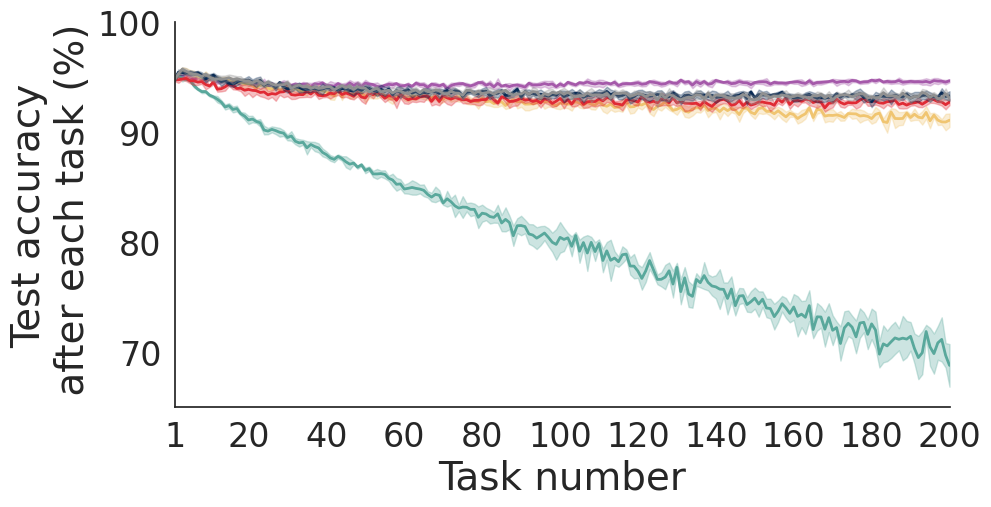

In [22]:
sns.set_theme(style="white")
window = 200
fig, ax = plt.subplots(figsize=(10, 5))
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0][:, :, :]*100
    full_acc_mean = jnp.mean(full_acc, axis=0)
    full_acc_std = jnp.std(full_acc, axis=0)
    vanishing_plasticity_mean = []
    vanishing_plasticity_std = []
    for k in range(full_acc_mean.shape[0]):
        vanishing_plasticity_mean.append(full_acc_mean[k][k])
        vanishing_plasticity_std.append(full_acc_std[k][k])
    vanishing_plasticity_mean = jnp.array(vanishing_plasticity_mean)
    vanishing_plasticity_std = jnp.array(vanishing_plasticity_std)
    task_range = jnp.arange(0, n_tasks)
    sns.lineplot(
        x=task_range, 
        y=vanishing_plasticity_mean, 
        color=colors[i],
        ax=ax, 
        linewidth= 3 if name == "MESU" else 2,
        zorder = 10 if name == "MESU" else 1,
        )
    ax.fill_between(task_range, 
                    vanishing_plasticity_mean-vanishing_plasticity_std, 
                    vanishing_plasticity_mean+vanishing_plasticity_std, 
                    color=colors[i],
                    alpha=0.3,
                    zorder = 10 if name == "MESU" else 1)
ax.set_xlabel("Task number", fontsize=AXESSIZE)
ax.set_ylabel("Test accuracy\n after each task (%)", fontsize=AXESSIZE)
ax.set_ylim(65, 100)
tickslabels = [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
ticks = [0, 19, 39, 59, 79, 99, 119, 139, 159, 179, 199]
ax.set_xticks(ticks)
ax.set_xlim(n_tasks-window, n_tasks-1)
ax.set_xticklabels(tickslabels)
ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=TICKSIZE)

plt.show()
fig.savefig(os.path.join(FOLDER, "pmnist-vanishing-plasticity-200.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(FOLDER, "pmnist-vanishing-plasticity-200.svg"), bbox_inches="tight")
plt.close()


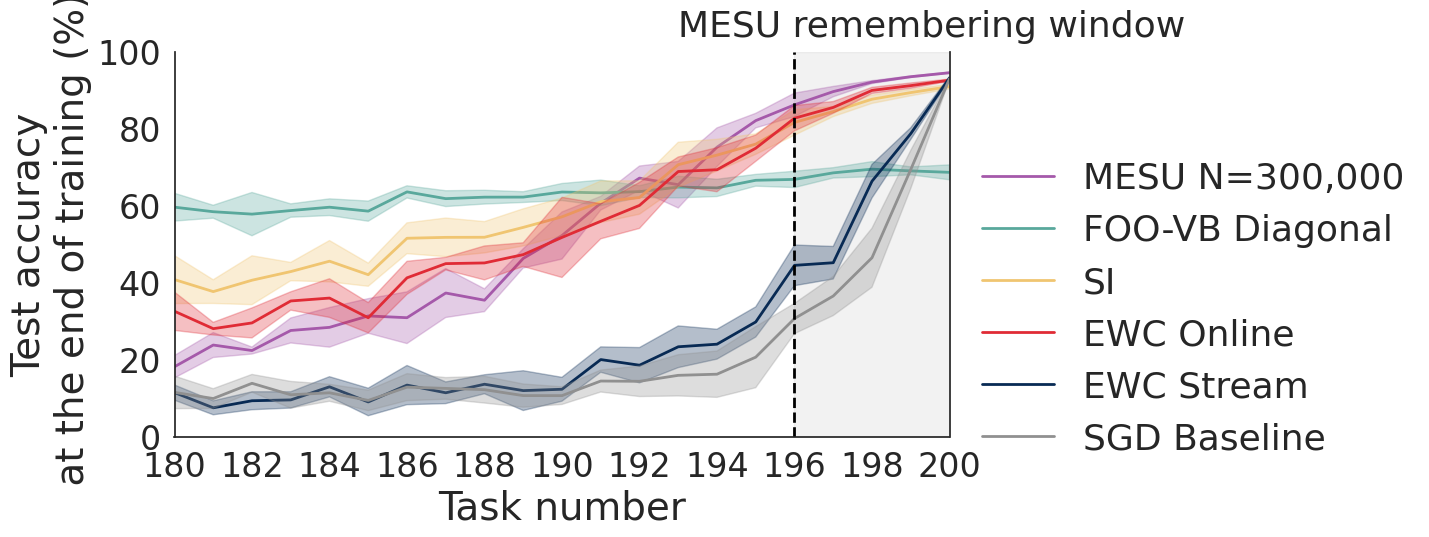

In [23]:
window = 20
fig, ax = plt.subplots(figsize=(10, 5))
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0][:, :, :]*100
    full_acc_mean = jnp.mean(full_acc, axis=0)
    full_acc_std = jnp.std(full_acc, axis=0)
    continual_learning_mean = full_acc_mean[-1]
    continual_learning_std = full_acc_std[-1]
    task_range = jnp.arange(0, n_tasks)
    sns.lineplot(
        x=task_range, 
        y=continual_learning_mean, 
        label=name, 
        color=colors[i], 
        ax=ax,  
        linewidth= 3 if name == "MESU" else 2,
        zorder = 10 if name == "MESU" else 1,
    )
    ax.fill_between(task_range, 
                    continual_learning_mean-continual_learning_std, 
                    continual_learning_mean+continual_learning_std, 
                    color=colors[i], 
                    alpha=0.3,
                    zorder = 10 if name == "MESU" else 1)
ax.set_xlabel("Task number", fontsize=AXESSIZE)
ax.set_ylabel("Test accuracy\n at the end of training (%)", fontsize=AXESSIZE)
ax.set_xlim(n_tasks-1-window, n_tasks-1)
ax.set_ylim(0, 100)
# tick labels from 190 to 199
ax.set_xticks(jnp.arange(n_tasks-1-window, n_tasks, window//10))
ax.set_xticklabels(jnp.arange(n_tasks-1-window, n_tasks, window//10)+1)
# yticks every 10
ax.set_yticks(jnp.arange(0, 101, 20))
# tick font size
ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
ax.spines['top'].set_visible(False)

# vline at 195
ax.axvline(195, color="black", linestyle="--", linewidth=2)
# text next to line "mesu forgetting window"
ax.text(192, 104, "MESU remembering window", fontsize=FONTSIZE, rotation=0)
# rectangular grey background between 195 and 200
plt.axvspan(195, 200, color='gray', alpha=0.1, zorder=0)

ax.legend(loc="upper left", fontsize=LEGENDSIZE, frameon=False, bbox_to_anchor=(1, 0.8))
plt.show()
# savefig as pdf
fig.savefig(os.path.join(FOLDER, f"pmnist-last-{window}-acc-200.pdf"), bbox_inches="tight")
# svg
fig.savefig(os.path.join(FOLDER, f"pmnist-last-{window}-acc-200.svg"), bbox_inches="tight")
plt.close()


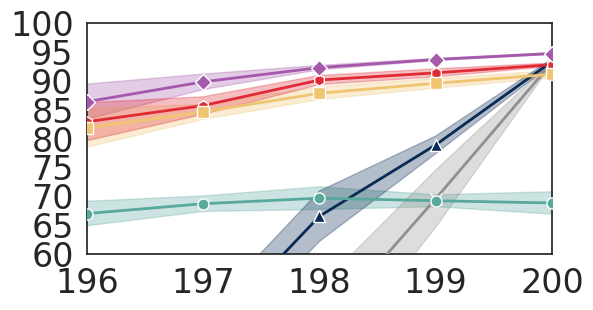

In [24]:
window = 5
fig, ax = plt.subplots(figsize=(6, 3))
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0][:, :, :]*100
    full_acc_mean = jnp.mean(full_acc, axis=0)
    full_acc_std = jnp.std(full_acc, axis=0)
    continual_learning_mean = full_acc_mean[-1]
    continual_learning_std = full_acc_std[-1]
    task_range = jnp.arange(0, n_tasks)
    sns.lineplot(
        x=task_range, 
        y=continual_learning_mean, 
        label=name, 
        color=colors[i],
        marker=markers[i], 
        markersize=8, 
        markeredgecolor="white",
        markeredgewidth=1,
        ax=ax,  
        linewidth=2, 
        zorder=10-i
    )
    ax.fill_between(task_range, continual_learning_mean-continual_learning_std, continual_learning_mean+continual_learning_std, color=colors[i], alpha=0.3)
ax.set_xlim(n_tasks-window, n_tasks-1)
# tick labels from 190 to 199
ax.set_xticks(jnp.arange(n_tasks-window, n_tasks, 1))
ax.set_xticklabels(jnp.arange(n_tasks-window, n_tasks, 1)+1)
# yticks every 10
ax.set_yticks(jnp.arange(0, 101, 5))
# tick font size
ax.tick_params(axis='both', which='both', labelsize=TICKSIZE)
# tick params
ax.set_ylim(60, 100)
#remove legend
ax.legend([],[], frameon=False)
# y ticks 
 
plt.show()
# savefig as pdf
fig.savefig(os.path.join(FOLDER, f"pmnist-zoom-last-{window}-acc-200.pdf"), bbox_inches="tight")
# svg
fig.savefig(os.path.join(FOLDER, f"pmnist-zoom-last-{window}-acc-200.svg"), bbox_inches="tight")
plt.close()


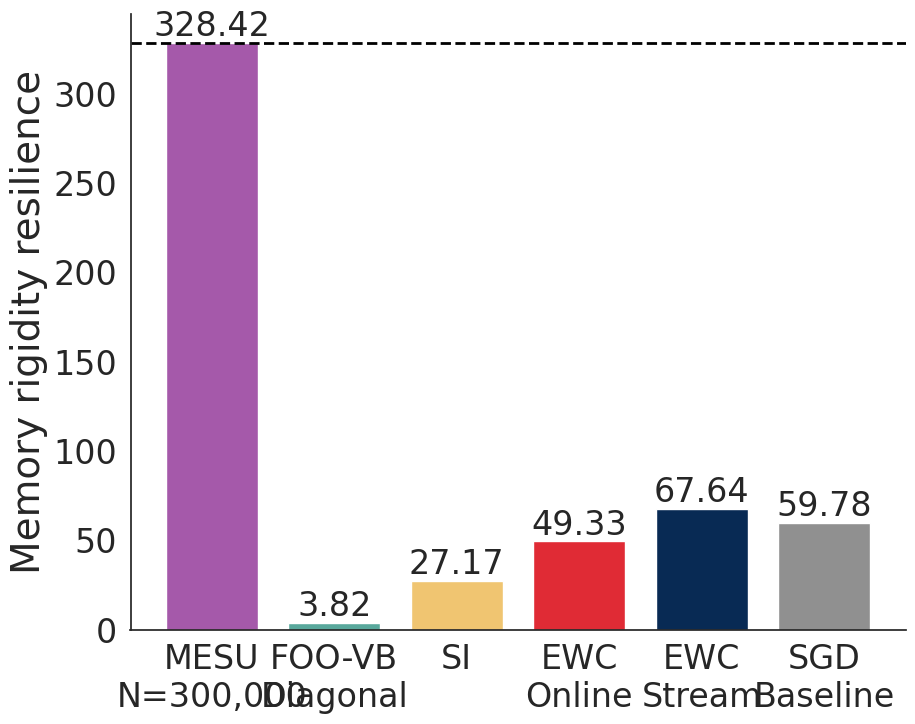

In [25]:

# First graph: Memory Rigidity
size = (10, 8)
bar_width = 0.75
names = [
    "MESU\nN=300,000",
    "FOO-VB\nDiagonal",
    "SI",
    "EWC\nOnline",
    "EWC\nStream",
    "SGD\nBaseline"
]
fig1, ax1 = plt.subplots(figsize=size)
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0]
    full_acc_mean = jnp.mean(full_acc, axis=0)
    vanishing_plasticity_mean = jnp.array([full_acc_mean[k][k] for k in range(full_acc_mean.shape[0])])
    first_bar_mean = 1/jnp.abs((vanishing_plasticity_mean[-1] - vanishing_plasticity_mean[0])) 
    ax1.bar(i, first_bar_mean, bar_width, label=name, color=colors[i])
    ax1.text(i, first_bar_mean+0.05, f"{first_bar_mean:.2f}", ha="center", va="bottom", fontsize=TICKSIZE)
    if "MESU" in name:
        # vertical dotted black line at max value
        ax1.axhline(first_bar_mean, color="black", linestyle="--", linewidth=2)
ax1.set_xticks(range(len(data)))
ax1.set_xticklabels(names, fontsize=TICKSIZE)
ax1.set_ylabel("Memory rigidity resilience", fontsize=AXESSIZE)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.set_ylim(0, 2.5)
ax1.tick_params(axis='both', which='both', labelsize=TICKSIZE)
fig1.savefig(os.path.join(FOLDER, "pmnist-bar-memory-rigidity.pdf"), bbox_inches="tight")
fig1.savefig(os.path.join(FOLDER, "pmnist-bar-memory-rigidity.svg"), bbox_inches="tight")
plt.show()

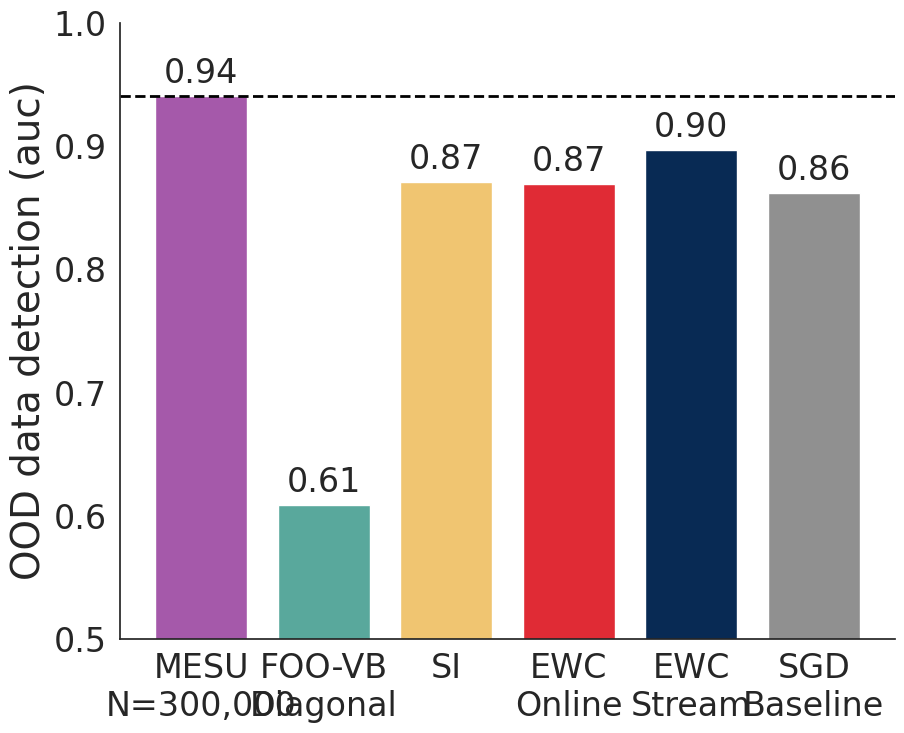

In [26]:
# Second graph: ROC AUC OoD Detection
fig2, ax2 = plt.subplots(figsize=size)
for i, alg, name in zip(range(len(data)), data, names):
    full_epistemic_uncertainty = alg[1]
    full_aleatoric_uncertainty = alg[2]
    full_epistemic_uncertainty_mean = jnp.mean(full_epistemic_uncertainty, axis=0)[-5:].mean()
    full_aleatoric_uncertainty_mean = jnp.mean(full_aleatoric_uncertainty, axis=0)[-5:].mean()
    if jnp.all(full_epistemic_uncertainty_mean == 0):
        second_bar_mean = full_aleatoric_uncertainty_mean
    else:
        second_bar_mean = full_epistemic_uncertainty_mean
    ax2.bar(i, second_bar_mean, bar_width, label=name, color=colors[i])
    ax2.text(i, second_bar_mean+0.005, f"{second_bar_mean:.2f}", ha="center", va="bottom", fontsize=TICKSIZE)
    if "MESU" in name:
        # vertical dotted black line at max value
        ax2.axhline(second_bar_mean, color="black", linestyle="--", linewidth=2)
ax2.set_xticks(range(len(data)))
ax2.set_xticklabels(names, fontsize=TICKSIZE)
ax2.set_ylabel("OOD data detection (auc)", fontsize=AXESSIZE)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='both', labelsize=TICKSIZE)
ax2.set_ylim(0.5, 1)
ax2.set_yticks(jnp.arange(0.5, 1.05, 0.1))
fig2.savefig(os.path.join(FOLDER, "pmnist-bar-ood-detection.pdf"), bbox_inches="tight")
fig2.savefig(os.path.join(FOLDER, "pmnist-bar-ood-detection.svg"), bbox_inches="tight")
plt.show()

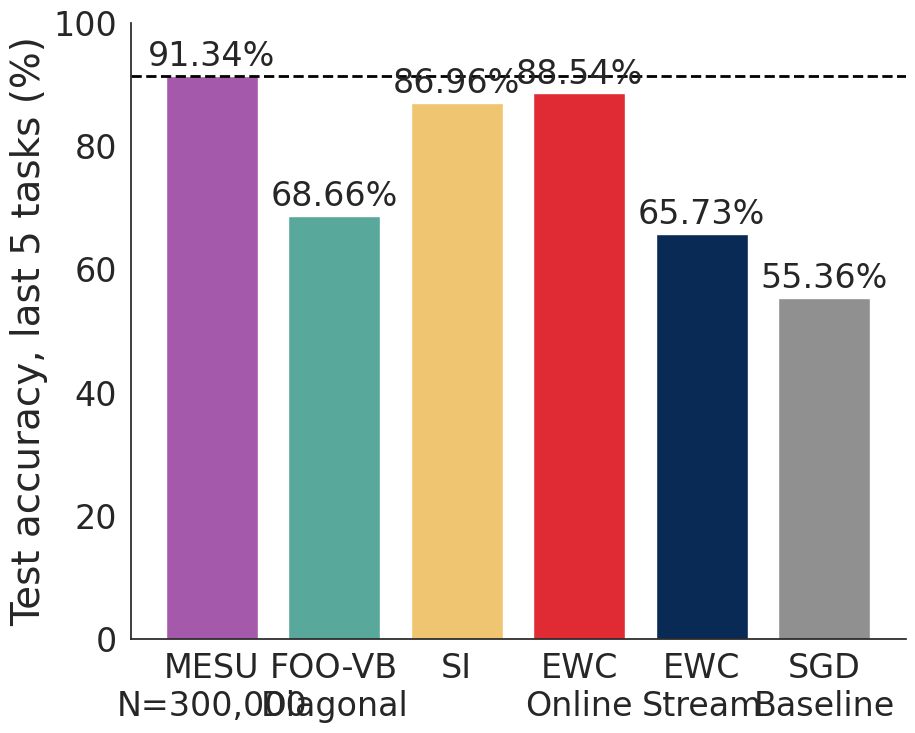

In [27]:
# Third graph: Mean accuracy on last five tasks
fig3, ax3 = plt.subplots(figsize=size)
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0]*100
    full_acc_mean = jnp.mean(full_acc, axis=0)
    continual_learning_mean = full_acc_mean[-1]
    third_bar_mean = jnp.mean(continual_learning_mean[-5:])
    ax3.bar(i, third_bar_mean, bar_width, label=name, color=colors[i])
    ax3.text(i, third_bar_mean+0.5, f"{third_bar_mean:.2f}%", ha="center", va="bottom", fontsize=TICKSIZE)
    if "MESU" in name:
        # vertical dotted black line at max value
        ax3.axhline(third_bar_mean, color="black", linestyle="--", linewidth=2)
ax3.set_xticks(range(len(data)))
ax3.set_xticklabels(names, fontsize=TICKSIZE)
ax3.set_ylabel("Test accuracy, last 5 tasks (%)", fontsize=AXESSIZE)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.tick_params(axis='both', which='both', labelsize=TICKSIZE)
ax3.set_ylim(40, 100)
ax3.set_yticks(jnp.arange(0, 101, 20))
fig3.savefig(os.path.join(FOLDER, "pmnist-bar-mean-accuracy.pdf"), bbox_inches="tight")
fig3.savefig(os.path.join(FOLDER, "pmnist-bar-mean-accuracy.svg"), bbox_inches="tight")
plt.show()
